In [33]:
import seaborn as sns
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_rel
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Removing id and Unnamed: 32 from data set
data = pd.read_csv("Cancer_Data.csv")
data.drop(["id", "Unnamed: 32"], axis=1, inplace=True)

#Replacing Malignant and Benign with 1 and 0
data['diagnosis'] = data['diagnosis'].replace({'M': 1, 'B': 0})

categorical_col = 'diagnosis'

numeric_cols = data.drop(columns=[categorical_col]).columns
cat_data = data[categorical_col] # Extract the categorical column separately

scalar = StandardScaler()
scaled_data = scalar.fit_transform(data[numeric_cols]) # Scale the numeric features

df = pd.DataFrame(scaled_data, columns=numeric_cols) # Create DataFrame with scaled features
df[categorical_col] = cat_data.values #Add the categorical column back

#Drop categories that are highly correlated
df.drop(["perimeter_mean", "radius_mean", "radius_se", "perimeter_se", "radius_worst", "perimeter_worst", "concavity_mean", "concave points_worst", "area_mean", "compactness_worst", "concavity_worst", "texture_worst", "compactness_mean", "area_worst"], axis=1, inplace=True)

<ipython-input-33-786541f3ffbf>:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['diagnosis'] = data['diagnosis'].replace({'M': 1, 'B': 0})


### Task 1

### Implementing Decision Tree Classifier

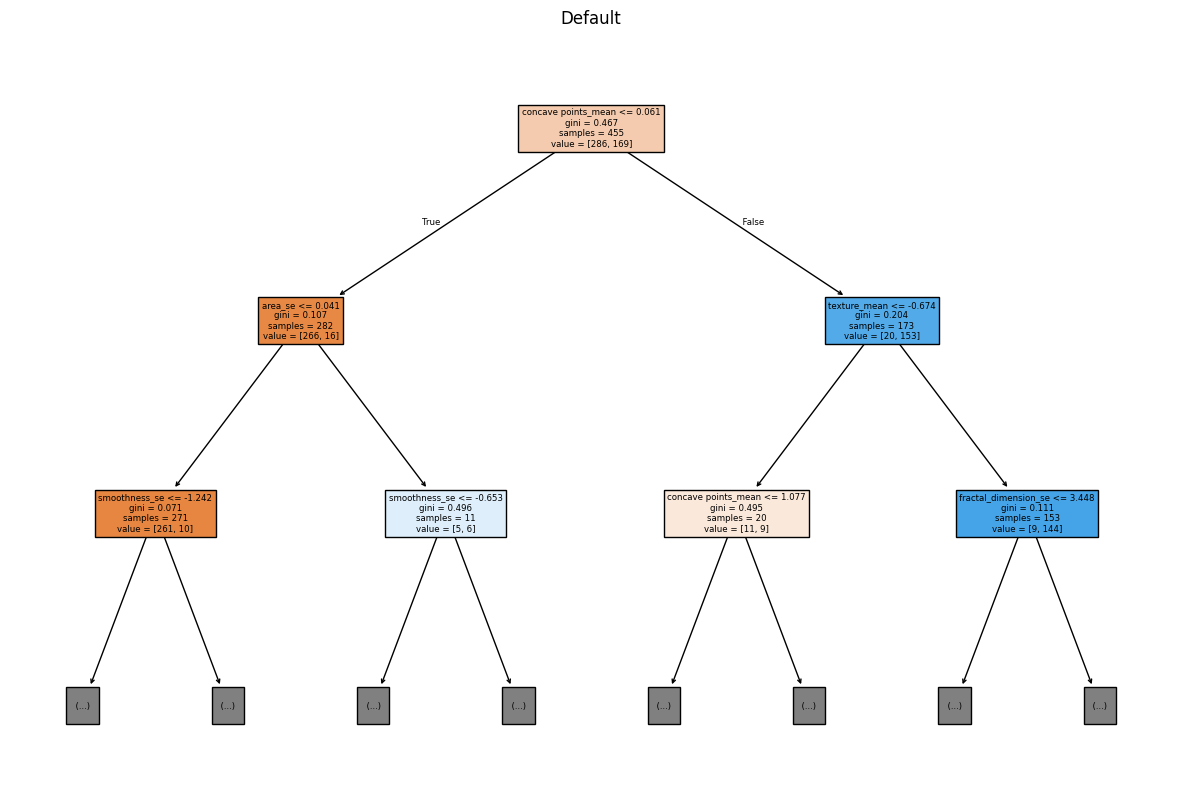

Default's Depth: 9



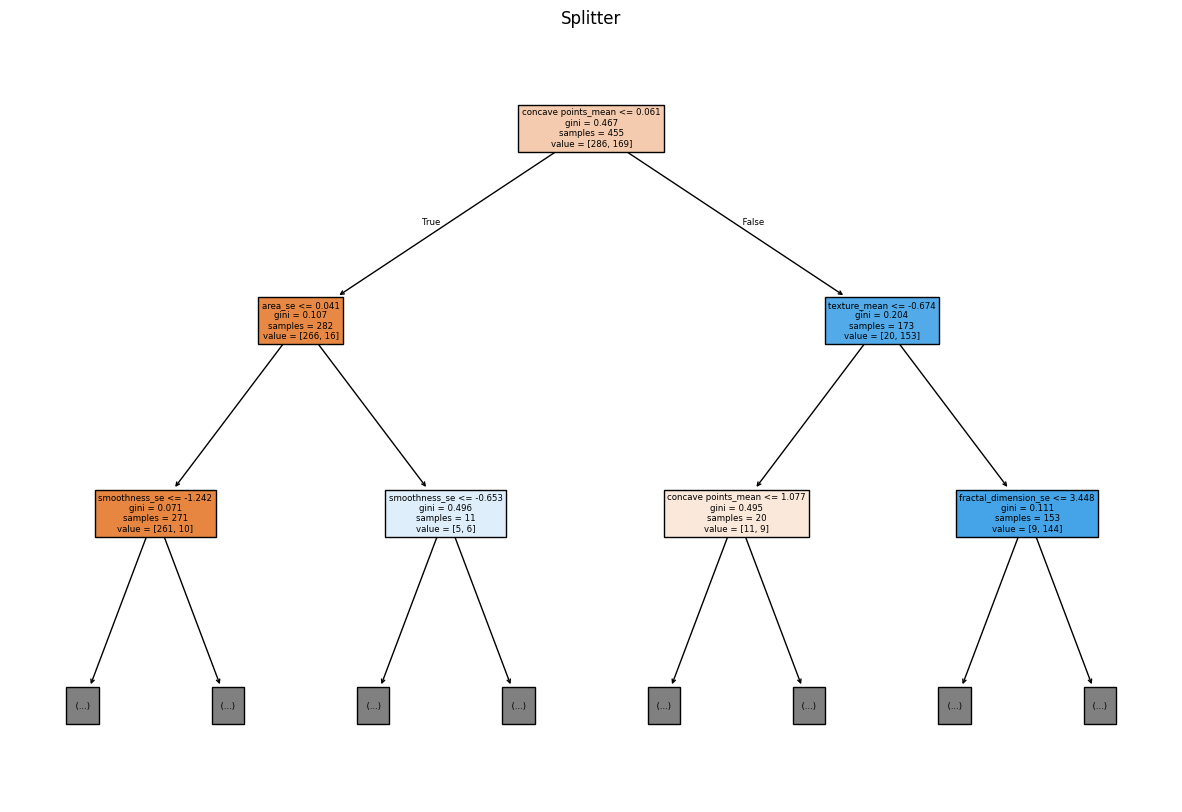

Splitter's Depth: 9



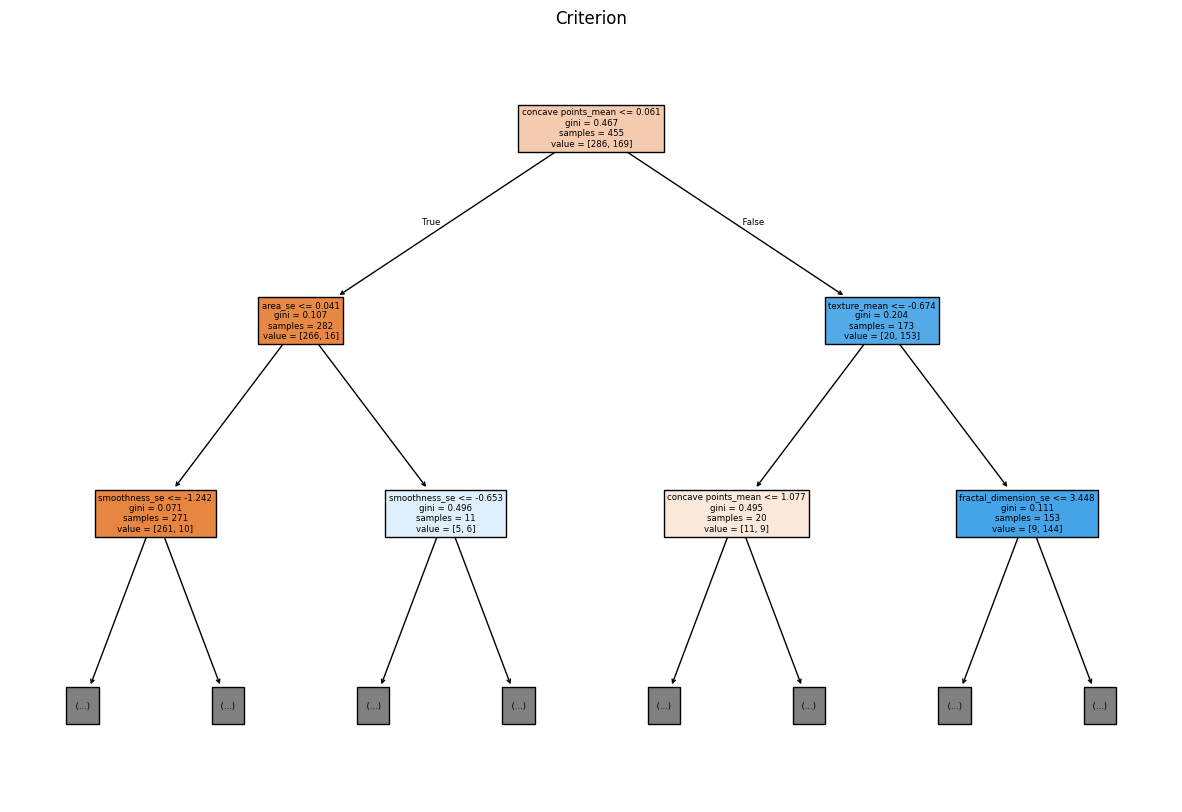

Criterion's Depth: 9



In [34]:
X = df.drop('diagnosis', axis=1)  # Drop the target column to get the feature matrix X
y = df['diagnosis']  # Extract the target labels (diagnosis) as y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Initializing trees
default_tree = DecisionTreeClassifier(max_depth=100, random_state=42)
splitter_tree = DecisionTreeClassifier(max_depth=100, splitter='best', random_state=42)
criterion_tree = DecisionTreeClassifier(max_depth=100, criterion='gini', random_state=42)

#Fitting trees
default_tree.fit(X_train, y_train)
splitter_tree.fit(X_train, y_train)
criterion_tree.fit(X_train, y_train)

def plot(tree, title):
  plt.figure(figsize=(15,10))
  plot_tree(tree, filled=True, feature_names=X.columns, max_depth=2)
  plt.title(title)
  plt.show()
  print(f"{title}'s Depth: {tree.get_depth()}\n")

plot(default_tree, "Default")
plot(splitter_tree, "Splitter")
plot(criterion_tree, "Criterion")

### How does the depth and complexity change the tree?
1. The depth/complexity of the tree can change how fitted the model is to the data as well as allowing it to capture more complex patterns. The cons of having a larger depth are generally that it is overfitted for the graph and it has a longer runtime.
2. Setting the splitter to 'best' chooses the best point to split from and then chooses the best feature at the end. This impacts the tree by making every decision at each node more better and increasing the accuracy of the tree.
3. By setting the criterion to gini, we notice that it has a max depth of 9. This can be a sign of greater accuracy in comparison to entropy, which had a max depth of 8, and a lower percentage of gini impurity.


### What is sensitivity analysis?
The process of changing the inputs of a model to see how they affect the outputs of the model. It is used to identify which inputs have the largest impact on the model, helps understand uncertainty in inputs after prediction, and focuses on measuring sensitive inputs more accurately.

In [35]:
print(X.columns.to_list())

['texture_mean', 'smoothness_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'texture_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'smoothness_worst', 'symmetry_worst', 'fractal_dimension_worst']


##Steps
1. Determine the model output $y_i$, the inputs X, and the $x_i$th variable in X.
2. Choose a set of values for each $x_i$
3. Take the Cartesian product of these values
4. For each $X_i$, calculate $y_i=f(X_i)$
5. Store the mapped value of $X_i$ to $y_i$
6. Visualize $y_i$ vs $X_i$

Source:

Sensitivity Analysis in Python — sensitivity 0.2.8 documentation. (n.d.). https://nickderobertis.github.io/sensitivity/auto_examples/sensitivity_analysis.html

https://exinfm.com/excel_lessons/lesson02/What_is_sens_analy.pdf


1. First I created a new tree with a smaller max depth so that it doesn't overfit. Then I call on the feature_importances_ function to find the most important features.

In [36]:
tree = DecisionTreeClassifier(max_depth=10, random_state=42)
tree.fit(X_train, y_train)

imp = tree.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': (imp * 100).round(2)
})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

feature_importance

,Feature,Importance
2,concave points_mean,74.96
0,texture_mean,7.44
12,fractal_dimension_se,4.12
14,symmetry_worst,2.98
6,area_se,2.57
7,smoothness_se,2.31
3,symmetry_mean,1.41
1,smoothness_mean,1.04
15,fractal_dimension_worst,0.94
13,smoothness_worst,0.90


The resulting call shows that the feature 'concavy points_mean' and 'texture_mean' hold the most importance.

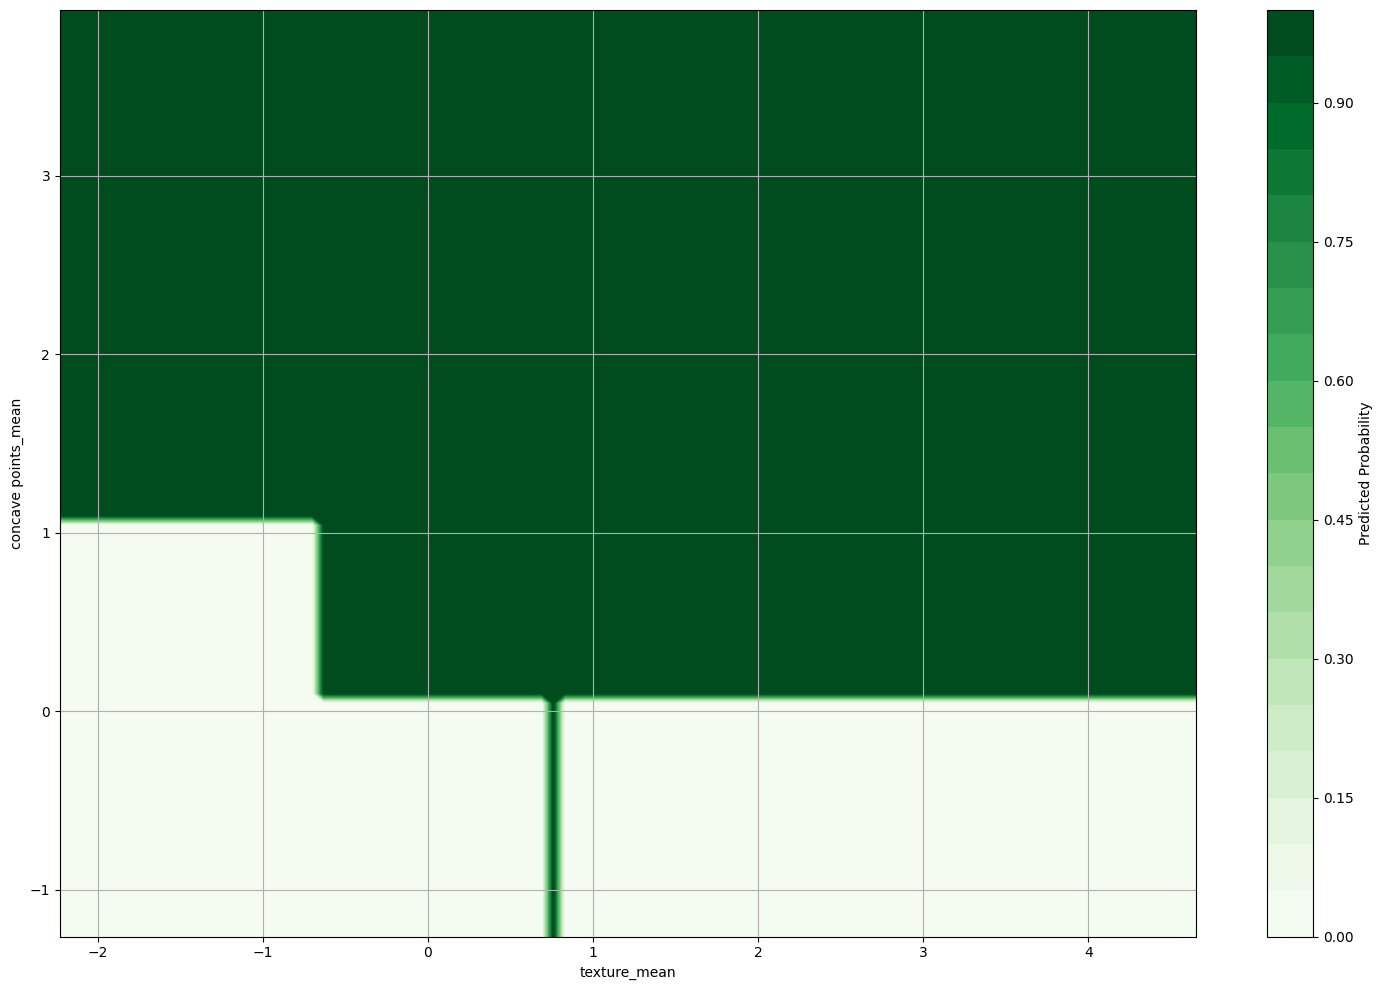

In [37]:
#Selecting features
feature_1 = "texture_mean"
feature_2 = "concave points_mean"

X_ref = X_train.median().to_frame().T

values_1 = np.linspace(X[feature_1].min(), X[feature_1].max(), 100)
values_2 = np.linspace(X[feature_2].min(), X[feature_2].max(), 100)

grid_1, grid_2 = np.meshgrid(values_1, values_2)
probs = np.zeros_like(grid_1)

for i in range(grid_1.shape[0]):
  for j in range(grid_2.shape[1]):
    row = X_ref.copy()
    row.at[0, feature_1] = grid_1[i][j]
    row.at[0, feature_2] = grid_2[i][j]
    probs[i][j] = tree.predict_proba(row)[0][1]


plt.figure(figsize=(15,10))
cp = plt.contourf(values_1, values_2, probs, levels=20, cmap='Greens', vmin=0, vmax=1)
plt.colorbar(cp, label="Predicted Probability")
plt.xlabel(feature_1)
plt.ylabel(feature_2)
plt.grid(True)
plt.tight_layout()
plt.show()



The output of the sensitivity analysis shows that there is a high probability when the concave points_mean is greater than 1.1 and the texture_mean is less than -0.7. When the texture_mean is greater than -0.7 but not equal to 0.7 and the concave points is greater than 0.1, there is also a high probability. Regardless of the concave points_mean, if the texture_mean is 0.7, then there is a high probability.

---
### Task 2

#Implementing Random Forest and Adaboost

In [38]:
#Creates models
rand_for = RandomForestClassifier(n_estimators=100, random_state=42)
ada_boost = AdaBoostClassifier(n_estimators=100, random_state=42)

#Model performance evaluator using folds
def kfold_eval(model, X, y, k, model_type):
  strat_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
  accuracy_scores= []
  f1_scores = []
  precision_scores = []

  start_time = time.time()

  for train_index, test_index in strat_fold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))

  run_time = time.time() - start_time

  return{
      "Model": model_type,
      "Folds": k,
      "Accuracy": np.mean(accuracy_scores),
      "F1": np.mean(f1_scores),
      "Precision": np.mean(precision_scores),
      "Runtime (s)": round(run_time, 3)
  }

#Runs evaluation function using these fold values
fold_sizes = [5, 10, 15]

#Stores all results here
results = []

#Testing each model for each fold and storing the results in results array
for i in fold_sizes:
  rand_forest_res = kfold_eval(rand_for, X, y, i, "Random Forest")
  results.append(rand_forest_res)

  ada_boost_res = kfold_eval(ada_boost, X, y, i, "AdaBoost")
  results.append(ada_boost_res)

#Returning results
results_df = pd.DataFrame(results)
results_df


,Model,Folds,Accuracy,F1,Precision,Runtime (s)
0,Random Forest,5,0.957864,0.942198,0.961605,1.440
1,AdaBoost,5,0.966620,0.954921,0.963391,2.324
2,Random Forest,10,0.950846,0.931902,0.949794,2.690
3,AdaBoost,10,0.966635,0.953687,0.967115,3.475
4,Random Forest,15,0.949075,0.929447,0.952045,4.372
5,AdaBoost,15,0.966619,0.953254,0.967828,5.849


###Comparisons

##Random Forest
- Random Forest showed a lower runtime in comparison to AdaBoost across the board.
- Random Forest has a slightly lower accuracy in comparison to AdaBoost for all folds, but showed the least difference in 5 folds.

##AdaBoost
- AdaBoost performed better than Random Forest in terms of Accuracy, F1, and Precision
- Had longer runtime in comparison to Random Forest, except for 10 fold

##Conclusion
- AdaBoost is a superior choice in comparison to Random Forest as it performs better than Random Forest in all metrics, outside of runtime which is only marginally worse (Average about 0.64)

###Task 3


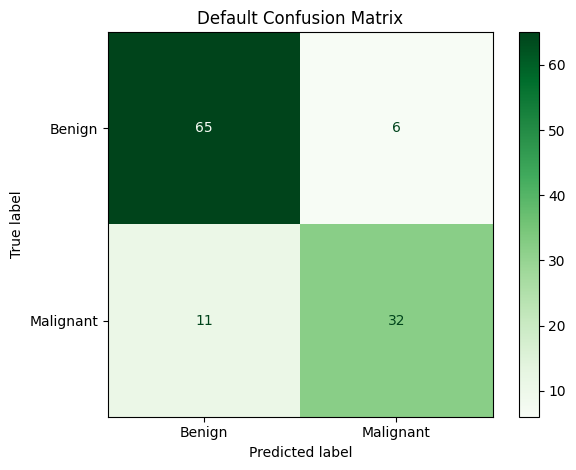

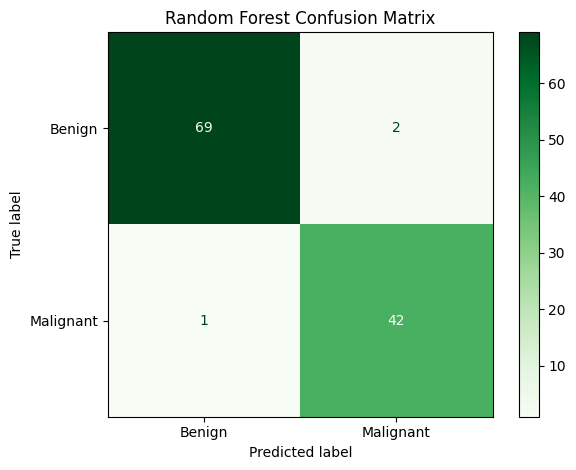

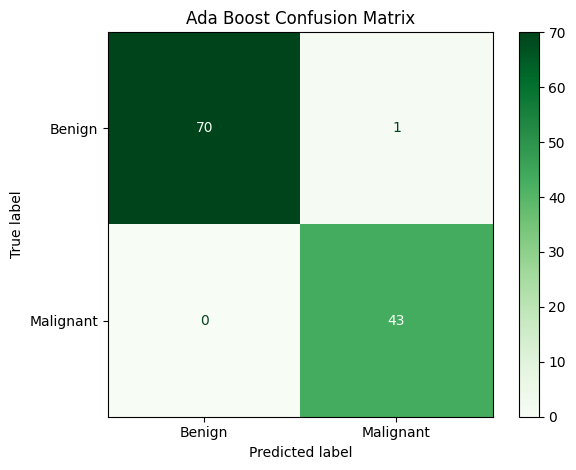

In [39]:
def c_matrix(y_true, y_pred, model_name):
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
  disp.plot(cmap=plt.cm.Greens)
  plt.title(f"{model_name} Confusion Matrix")
  plt.grid(False)
  plt.tight_layout()
  plt.show()

default_tree = DecisionTreeClassifier(max_depth=10, random_state=42)
rand_for = RandomForestClassifier(n_estimators=100, random_state=42)
ada_boost = AdaBoostClassifier(n_estimators=100, random_state=42)

strat_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_index, test_index = next(strat_fold.split(X, y))

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

default_tree.fit(X_train, y_train)
rand_for.fit(X_train, y_train)
ada_boost.fit(X_train, y_train)

y_pred_default = default_tree.predict(X_test)
y_pred_rand_for = rand_for.predict(X_test)
y_pred_ada_boost = ada_boost.predict(X_test)

c_matrix(y_test, y_pred_default, "Default")
c_matrix(y_test, y_pred_rand_for, "Random Forest")
c_matrix(y_test, y_pred_ada_boost, "Ada Boost")


#Default Tree
  - While the default tree is quite accurate, it has more false positives and false negatives than the other two trees.

#Random Forest Tree
- The Random Forest Tree is a stark improvement compared to the Default tree. It is able to predict with high accuracy both positive and negative cases.

#Ada Boost Tree
- The Ada Boost Tree is even better at predicting than the Random Forest Tree. It has a 100% accuracy for the false negatives and for the false positives, it is 98.5% accurate.

In [40]:
#15 Folds
def kfold_f1(model, X, y):
  strat_fold = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
  f1_scores = []

  for train_index, test_index in strat_fold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    f1_scores.append(f1_score(y_test, y_pred))

  return f1_scores

default_tree = DecisionTreeClassifier(max_depth=10, random_state=42)
rand_for = RandomForestClassifier(n_estimators=100, random_state=42)
ada_boost = AdaBoostClassifier(n_estimators=100, random_state=42)

default_scores = kfold_f1(default_tree, X, y)
rf_scores = kfold_f1(rand_for, X, y)
ada_scores = kfold_f1(ada_boost, X, y)

#Default to Random Forest
t_stat_default, p_value_default = ttest_rel(default_scores, rf_scores, axis=0, nan_policy='propagate', alternative='two-sided')
#Default to Ada Boost
t_stat_ada, p_value_ada = ttest_rel(default_scores, ada_scores, axis=0, nan_policy='propagate', alternative='two-sided')
#Random Forest to Ada Boost
t_stat_rf, p_value_rf = ttest_rel(rf_scores, ada_scores, axis=0, nan_policy='propagate', alternative='two-sided')

print(f"Default vs Random Forest: t-statistic = {t_stat_default:.4f}, p-value = {p_value_default:.4f}")
print(f"Default vs Ada Boost: t-statistic = {t_stat_ada:.4f}, p-value = {p_value_ada:.4f}")
print(f"Random Forest vs Ada Boost: t-statistic = {t_stat_rf:.4f}, p-value = {p_value_rf:.4f}")

Default vs Random Forest: t-statistic = -3.6430, p-value = 0.0027
Default vs Ada Boost: t-statistic = -5.0650, p-value = 0.0002
Random Forest vs Ada Boost: t-statistic = -2.4474, p-value = 0.0282


I decided to use 15 fold for my stratified k fold, use the F1 score to do the t-test as it showed the largest variance among the models, and also a threshold p-value of 0.01.

---
###Evaluation
- The difference between the Default and Random Forest is significant because the p value is much less than 0.01. We can also say that the Random Forest model outperformed the Default tree.
- The difference betwen the Default and Ada Boost is extremely significant because the p-value is much less than 0.01. We can also say that the Ada Boost model outperformed the Default tree.
- The difference between the Random Forest and Ada Boost is not significant because the p value is greater than 0.01. However, we can also conclude that Ada Boost is marginally better than Random Forest.

### Default Tree
- Has a higher variance but a low bias. This is due to the complexity of the model being too high
- Tends to overfit on data, as captured on the confusion matrix with how it wasn't getting false positives and false negatives

### Random Forest
- Has a much lower variance but still has about the same bias

### ADA Boost
- Has a low variance and lowers bias even more

###References

https://www.geeksforgeeks.org/boosting-in-machine-learning-boosting-and-adaboost/

https://scikit-learn.org/0.21/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#:~:text=An%20AdaBoost%20%5B1%5D%20classifier%20is,focus%20more%20on%20difficult%20cases.

https://www.google.com/url?q=https%3A%2F%2Fexinfm.com%2Fexcel_lessons%2Flesson02%2FWhat_is_sens_analy.pdf

https://nickderobertis.github.io/sensitivity/auto_examples/sensitivity_analysis.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html

https://www.datacamp.com/tutorial/ensemble-learning-python
